In [13]:
options(warn = -1)
library(tidyverse)
library(caret)
library(randomForest)
library(ranger) #RandomForest plus rapide
library(rpart)
library(pROC)

In [39]:
df <- read_csv("data/Attempt 8.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  `Destination IP` = col_character(),
  Label = col_character()
)
See spec(...) for full column specifications.


In [15]:
df <- df %>% 
  mutate_at(c('Destination IP', 'Protocol', 'Label'), funs(factor))

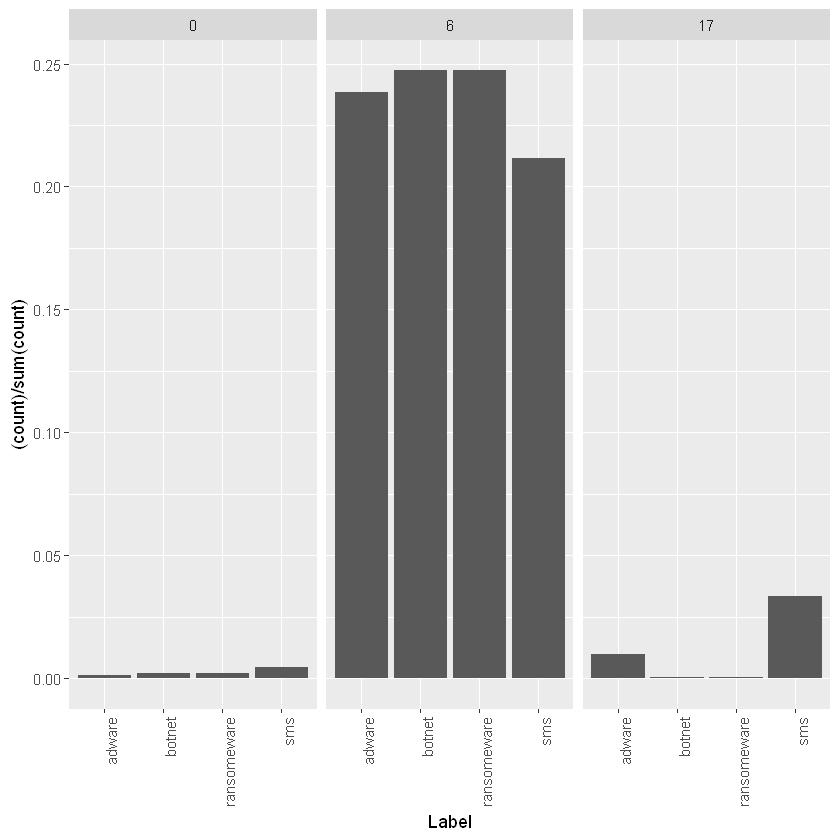

In [16]:
ggplot(df) + 
  aes(x = Label) + geom_bar(aes(y = (..count..)/sum(..count..))) + 
  facet_grid(.~Protocol) +
  theme(axis.text.x=element_text(angle=90, hjust=1))

In [22]:
length(unique(df$`Destination Port`))

[1] 325

In [71]:
ip_split <- function(ip){
    ipMain <- paste(str_split(ip, "\\.")[[1]][1], str_split(ip, "\\.")[[1]][2], sep = ".")
    return(ipMain)
}


In [76]:
df %>%
select(IP = `Destination IP`) %>% rowwise() %>% mutate(sub_label = paste(str_split(`IP`, "\\.")[[1]][1], str_split(`IP`, "\\.")[[1]][2], sep = "."))

IP,sub_label
169.53.71.249,169.53
10.42.0.211,10.42
172.217.0.228,172.217
10.42.0.211,10.42
172.217.0.228,172.217
172.217.0.228,172.217
172.217.0.228,172.217
10.42.0.211,10.42
172.217.0.228,172.217
172.217.0.228,172.217


In [27]:
df  %>% 
group_by(`Destination IP`) %>% 
summarise(n = n()) %>% 
top_n(20)

Selecting by n


Destination IP,n
10.42.0.1,153
10.42.0.151,188
10.42.0.42,145
103.235.46.211,41
104.192.108.22,41
119.146.74.33,142
119.146.74.48,39
121.12.98.63,35
121.12.98.64,51
172.217.12.202,41


In [25]:
df  %>% 
group_by(`Source Port`) %>% 
summarise(n = n()) %>% 
top_n(10)

Selecting by n


Source Port,n
0,43
80,84
443,272
5222,7
37729,7
37838,7
38176,7
38193,7
40534,7
41091,7


In [24]:
df  %>% 
group_by(`Destination Port`) %>% 
summarise(n = n()) %>% 
top_n(10)

Selecting by n


Destination Port,n
0,43
53,152
80,1327
443,2045
1900,4
5222,13
5228,20
16100,5
48962,4
51618,4


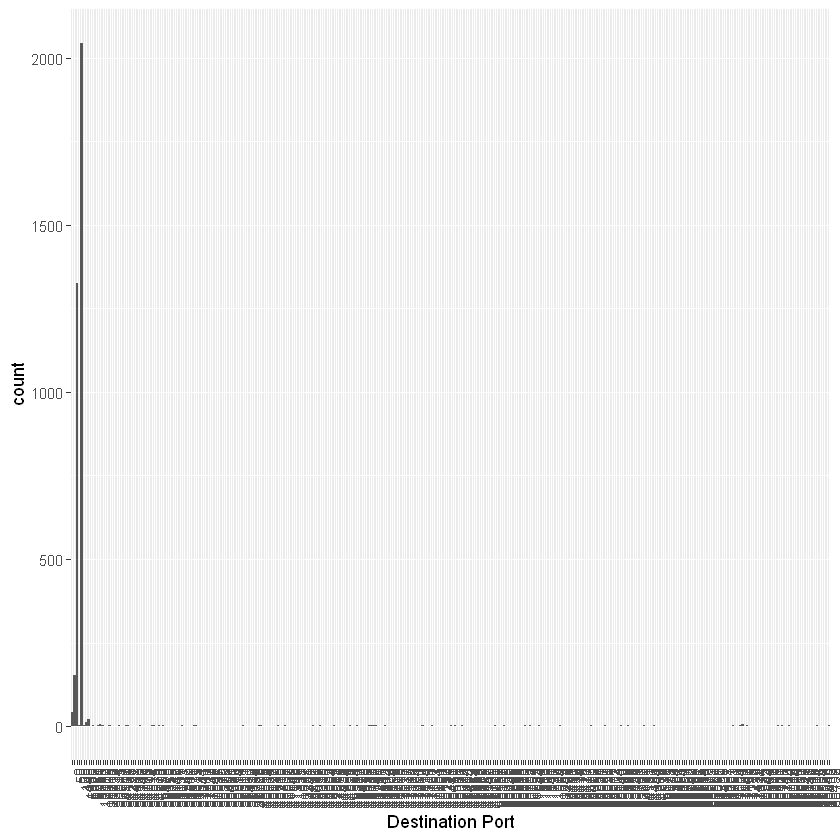

In [17]:
ggplot(df %>% mutate(`Destination Port` = as.factor(`Destination Port`))) +
  aes(x = `Destination Port`) + geom_bar() + #facet_grid(.~Label) +
  theme(axis.text.x=element_text(angle=90, hjust=1))